In [7]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SolveLinSys
import time
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

In [8]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def compute_prob(μ_2_state, λ_2p_state, λ_2p_prior):
    λ_2p = np.zeros(λ_2p_state.shape[0]*μ_2_state.shape[0])
    μ_2 = np.zeros_like(λ_2p)
    π_o = np.zeros_like(λ_2p)
    for i in range(λ_2p_state.shape[0]):
        for j in range(μ_2_state.shape[0]):
            idx = i*μ_2_state.shape[0] + j
            λ_2p[idx] = λ_2p_state[i]
            μ_2[idx] = μ_2_state[j]
            π_o[idx] = 1./len(μ_2_state) * λ_2p_prior[i]
    return μ_2, λ_2p, π_o

Equation:

\begin{align}
0 = \max_e \min_{h_2} \min_{\pi_j:\sum_j^J{\pi_j}=1} &-\delta \phi(y,z_2) + \delta\eta\log e  + \frac{\partial \phi}{\partial y}(y, z_2) z_2 e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \sum_{j}^J \pi_j \mu_{2,j}) \right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\sum_{j}^J \pi_{j}\left(\frac{d}{d \tau}\Lambda_j(y)z_2 e\right)\\
& + \xi_a \sum_{j}^J \pi_{j} \left(\log \pi_j - \log \pi_j^o\right)
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $\pi_j$ gives:
$$
\pi_j \propto \exp\left(-\frac{1}{\xi_a}\left[(\eta-1)\left(\frac{d}{d \tau}\Lambda_j(z_2 y) z_2 e \right) + \frac{\partial \phi}{\partial z_2}(y, z_2)\rho \mu_{2,j} \right]\right)\pi_j^o
$$

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2)z_2 + (\eta-1)\sum_{j}^J\pi_j\frac{d}{d \tau}\Lambda_j(y)z_2}
$$

In [9]:
def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o  = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat

    d_Λ = np.array([λ_1 + λ_2*y_mat + λ_2p_j*(y_mat>λ_bar)*(y_mat-λ_bar) for λ_2p_j in λ_2p])
    d_Λ_z = d_Λ * z_mat

    π = np.ones_like(d_Λ)
    μ_2_new = np.ones_like(d_Λ)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
        μ_2_new[i] = μ_2[i]
    π_o = π.copy()
    μ_2 = μ_2_new

    mean = - ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    var = std**2/2.    
    e = - δ*η / ((η-1)*np.sum(π*d_Λ_z, axis=0))
    e_old = e.copy()
    
    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        log_π_ratio = -((η-1.)*d_Λ_z*e+v0_dz*ρ*μ_2)/ξ_a
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-12

        e_new = - δ*η / (v0_dy*z_mat + (η-1)*np.sum(π*d_Λ_z, axis=0))
        e_new[e_new<=0] = 1e-12
        e = e_new * 0.5 + e_old * 0.5
        e_old = e.copy()
        
        A = np.ones_like(z_mat)*(-δ)
        B_z = np.sum(π*mean, axis=0)
        B_y = z_mat*e
        C_zz = var
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + (η-1)*np.sum(π*d_Λ_z*e, axis=0)\
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")


        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e, π

In [16]:
# Model parameters
η = .032
# ξ_a = 1./4000
ξ_a = 1000.
δ = .01
# Z process
μ_2_mean = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/3.
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.

# three damage
λ_2p_state = np.array([0., 0.0197*2, 0.3853*2])
λ_2p_prior = np.array([0.4875, 0.4875, 0.025])
μ_2_state = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.

μ_2, λ_2p, π_o = compute_prob(μ_2_state, λ_2p_state, λ_2p_prior)
pde_paras = (η, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 10
z_min = np.max([μ_2_mean - 3*np.sqrt(σ_2**2*μ_2_mean/(2*ρ)), 1e-9])
z_max = μ_2_mean + 3*np.sqrt(σ_2**2*μ_2_mean/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 10
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)

In [17]:
ϕ_grid, e_grid, π_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                         v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.0012724334743873453; RHS Error 0.0015429548016951003
Iteration 2: LHS Error: 0.0012345745117139841; RHS Error 0.0014169857722176906
Iteration 3: LHS Error: 0.001208929160132783; RHS Error 0.001337828101052429
Iteration 4: LHS Error: 0.0011822608693084291; RHS Error 0.001276110495020996
Iteration 5: LHS Error: 0.0011529334528302916; RHS Error 0.001223338566298764
Iteration 6: LHS Error: 0.0011223179633703846; RHS Error 0.0011768261033201892
Iteration 7: LHS Error: 0.0010919749984807494; RHS Error 0.001135505658756134
Iteration 8: LHS Error: 0.0010629157523988058; RHS Error 0.0010986848379724785
Iteration 9: LHS Error: 0.0010356075432782514; RHS Error 0.0010657394104264194
Iteration 10: LHS Error: 0.0010101621644159151; RHS Error 0.0010360846844818632
Iteration 11: LHS Error: 0.0009865049545135837; RHS Error 0.0010091991305548659
Iteration 12: LHS Error: 0.0009644826716107037; RHS Error 0.0009846389941587691
Iteration 13: LHS Error: 0.0009439213377547134; RHS Er

Iteration 136: LHS Error: 0.00025805754668493247; RHS Error 0.00025900615326610407
Iteration 137: LHS Error: 0.0002567826565538639; RHS Error 0.00025773130947166626
Iteration 138: LHS Error: 0.00025551406323771897; RHS Error 0.0002564627615532939
Iteration 139: LHS Error: 0.00025425173637640824; RHS Error 0.00025520047952246093
Iteration 140: LHS Error: 0.0002529956442439696; RHS Error 0.00025394443236751146
Iteration 141: LHS Error: 0.00025174575679424993; RHS Error 0.00025269459000723976
Iteration 142: LHS Error: 0.00025050204303778134; RHS Error 0.0002514509207802335
Iteration 143: LHS Error: 0.0002492644723585749; RHS Error 0.00025021339490951405
Iteration 144: LHS Error: 0.0002480330152556734; RHS Error 0.00024898198143459186
Iteration 145: LHS Error: 0.0002468076398977753; RHS Error 0.000247756650935133
Iteration 146: LHS Error: 0.0002455883179489707; RHS Error 0.00024653737306596616
Iteration 147: LHS Error: 0.0002443750190679467; RHS Error 0.00024532411758380635
Iteration 148: 

Iteration 292: LHS Error: 0.00011916742144195414; RHS Error 0.00012012098666182677
Iteration 293: LHS Error: 0.00011857861842606843; RHS Error 0.00011953220376772605
Iteration 294: LHS Error: 0.00011799272418600015; RHS Error 0.00011894633113373836
Iteration 295: LHS Error: 0.0001174097245096456; RHS Error 0.00011836335115407415
Iteration 296: LHS Error: 0.00011682960500322692; RHS Error 0.00011778325285048468
Iteration 297: LHS Error: 0.00011625235121008604; RHS Error 0.00011720601840753392
Iteration 298: LHS Error: 0.00011567794952357935; RHS Error 0.00011663163742537953
Iteration 299: LHS Error: 0.00011510638580237986; RHS Error 0.0001160600924122234
Iteration 300: LHS Error: 0.00011453764445606973; RHS Error 0.00011549137142408361
Iteration 301: LHS Error: 0.00011397171334548428; RHS Error 0.00011492546089131951
Iteration 302: LHS Error: 0.00011340857851269148; RHS Error 0.00011436234591238355
Iteration 303: LHS Error: 0.00011284822517186599; RHS Error 0.00011380201215023728
Iterat

Iteration 443: LHS Error: 5.640462804709645e-05; RHS Error 5.736038921474627e-05
Iteration 444: LHS Error: 5.612590301617981e-05; RHS Error 5.708167399522525e-05
Iteration 445: LHS Error: 5.5848555704465785e-05; RHS Error 5.6804335870928055e-05
Iteration 446: LHS Error: 5.557257826893647e-05; RHS Error 5.652836864968318e-05
Iteration 447: LHS Error: 5.529796464116832e-05; RHS Error 5.625376453312288e-05
Iteration 448: LHS Error: 5.5024707621018076e-05; RHS Error 5.598051730307713e-05
Iteration 449: LHS Error: 5.475280083611089e-05; RHS Error 5.5708619488386007e-05
Iteration 450: LHS Error: 5.4482237660705146e-05; RHS Error 5.543806529611882e-05
Iteration 451: LHS Error: 5.421301099696463e-05; RHS Error 5.51688481648782e-05
Iteration 452: LHS Error: 5.3945114643044745e-05; RHS Error 5.4900960964976734e-05
Iteration 453: LHS Error: 5.36785421929864e-05; RHS Error 5.463439821338427e-05
Iteration 454: LHS Error: 5.341328641768339e-05; RHS Error 5.436915120303877e-05
Iteration 455: LHS Erro

Iteration 601: LHS Error: 2.5785505519015928e-05; RHS Error 2.6742320351491925e-05
Iteration 602: LHS Error: 2.5658071962100792e-05; RHS Error 2.6614890856603926e-05
Iteration 603: LHS Error: 2.5531268533898754e-05; RHS Error 2.6488091735202247e-05
Iteration 604: LHS Error: 2.5405091014465975e-05; RHS Error 2.636191818174399e-05
Iteration 605: LHS Error: 2.527953762916646e-05; RHS Error 2.6236370100125037e-05
Iteration 606: LHS Error: 2.5154604116561785e-05; RHS Error 2.6111440301988982e-05
Iteration 607: LHS Error: 2.50302880700215e-05; RHS Error 2.5987128790633208e-05
Iteration 608: LHS Error: 2.4906586574072187e-05; RHS Error 2.586343189995747e-05
Iteration 609: LHS Error: 2.4783496093569446e-05; RHS Error 2.5740345168705962e-05
Iteration 610: LHS Error: 2.4661014183205432e-05; RHS Error 2.5617867118716913e-05
Iteration 611: LHS Error: 2.4539137032125735e-05; RHS Error 2.5495994003220065e-05
Iteration 612: LHS Error: 2.4417862737505236e-05; RHS Error 2.537472407878e-05
Iteration 613

Iteration 756: LHS Error: 1.1963438381570879e-05; RHS Error 2.420940991606764e-05
Iteration 757: LHS Error: 1.1904308187676849e-05; RHS Error 2.4209102295625175e-05
Iteration 758: LHS Error: 1.1845470469937225e-05; RHS Error 2.4208842012633943e-05
Iteration 759: LHS Error: 1.1786923548098849e-05; RHS Error 2.4208630845970686e-05
Iteration 760: LHS Error: 1.1728665582411146e-05; RHS Error 2.4208466028658327e-05
Iteration 761: LHS Error: 1.1670696074203568e-05; RHS Error 2.4208348985094467e-05
Iteration 762: LHS Error: 1.1613012967412462e-05; RHS Error 2.420827758475581e-05
Iteration 763: LHS Error: 1.155561429025398e-05; RHS Error 2.420825158408967e-05
Iteration 764: LHS Error: 1.1498499866549605e-05; RHS Error 2.4208271707506818e-05
Iteration 765: LHS Error: 1.1441667247105713e-05; RHS Error 2.4208335859261364e-05
Iteration 766: LHS Error: 1.138511624575178e-05; RHS Error 2.4208444264620923e-05
Iteration 767: LHS Error: 1.132884452038907e-05; RHS Error 2.4208596182690844e-05
Iteration 

Iteration 908: LHS Error: 5.633248894479359e-06; RHS Error 2.44825087480446e-05
Iteration 909: LHS Error: 5.605403317468505e-06; RHS Error 2.4485305738650848e-05
Iteration 910: LHS Error: 5.577695867231558e-06; RHS Error 2.448810569194318e-05
Iteration 911: LHS Error: 5.550124870315476e-06; RHS Error 2.4490907965642834e-05
Iteration 912: LHS Error: 5.522690218501269e-06; RHS Error 2.4493713298350287e-05
Iteration 913: LHS Error: 5.495391426441065e-06; RHS Error 2.4496521191344793e-05
Iteration 914: LHS Error: 5.4682272839085e-06; RHS Error 2.4499331301577735e-05
Iteration 915: LHS Error: 5.441197484606919e-06; RHS Error 2.4502143698186736e-05
Iteration 916: LHS Error: 5.414301422188017e-06; RHS Error 2.4504958511918336e-05
Iteration 917: LHS Error: 5.387538112258672e-06; RHS Error 2.4507775216065604e-05
Iteration 918: LHS Error: 5.3609071712229506e-06; RHS Error 2.4510593898621627e-05
Iteration 919: LHS Error: 5.334407622195614e-06; RHS Error 2.4513414395986805e-05
Iteration 920: LHS E

Iteration 1061: LHS Error: 2.639236292942271e-06; RHS Error 2.489441719594578e-05
Iteration 1062: LHS Error: 2.626189056276207e-06; RHS Error 2.4896793457157996e-05
Iteration 1063: LHS Error: 2.6132065392286963e-06; RHS Error 2.4899163866539688e-05
Iteration 1064: LHS Error: 2.6002881389625143e-06; RHS Error 2.4901528774078584e-05
Iteration 1065: LHS Error: 2.587433392695071e-06; RHS Error 2.4903888060739477e-05
Iteration 1066: LHS Error: 2.5746425042078025e-06; RHS Error 2.4906241680845362e-05
Iteration 1067: LHS Error: 2.561914634519047e-06; RHS Error 2.4908589522135345e-05
Iteration 1068: LHS Error: 2.5492497231771605e-06; RHS Error 2.491093174415205e-05
Iteration 1069: LHS Error: 2.536647405251835e-06; RHS Error 2.4913268099254274e-05
Iteration 1070: LHS Error: 2.524107255014174e-06; RHS Error 2.491559903939841e-05
Iteration 1071: LHS Error: 2.511629361254264e-06; RHS Error 2.4917924154720366e-05
Iteration 1072: LHS Error: 2.49921336102632e-06; RHS Error 2.4920243693887442e-05
Iter

Iteration 1218: LHS Error: 1.2121509359031002e-06; RHS Error 2.5196963630834315e-05
Iteration 1219: LHS Error: 1.2061577792099598e-06; RHS Error 2.5198452087262305e-05
Iteration 1220: LHS Error: 1.200194906139651e-06; RHS Error 2.5199935532431526e-05
Iteration 1221: LHS Error: 1.1942610948223464e-06; RHS Error 2.520141384380111e-05
Iteration 1222: LHS Error: 1.1883565055603729e-06; RHS Error 2.520288708671907e-05
Iteration 1223: LHS Error: 1.182481506392663e-06; RHS Error 2.520435521769621e-05
Iteration 1224: LHS Error: 1.1766355957343322e-06; RHS Error 2.5205818265966635e-05
Iteration 1225: LHS Error: 1.170820206633505e-06; RHS Error 2.5207276543136444e-05
Iteration 1226: LHS Error: 1.16502997177248e-06; RHS Error 2.5208731739892833e-05
Iteration 1227: LHS Error: 1.1592695700335387e-06; RHS Error 2.5210183154534302e-05
Iteration 1228: LHS Error: 1.1535380956689822e-06; RHS Error 2.5211629464252992e-05
Iteration 1229: LHS Error: 1.1478351415322718e-06; RHS Error 2.5213069033017533e-05


Iteration 1375: LHS Error: 5.566767524445293e-07; RHS Error 2.537560479179185e-05
Iteration 1376: LHS Error: 5.539247833891148e-07; RHS Error 2.5376436505509603e-05
Iteration 1377: LHS Error: 5.511855108442099e-07; RHS Error 2.5377265468854294e-05
Iteration 1378: LHS Error: 5.484602955962981e-07; RHS Error 2.5378090398005216e-05
Iteration 1379: LHS Error: 5.457485800913764e-07; RHS Error 2.5378912787518367e-05
Iteration 1380: LHS Error: 5.430500556458107e-07; RHS Error 2.5379731681820237e-05
Iteration 1381: LHS Error: 5.403661064301568e-07; RHS Error 2.5380547038721915e-05
Iteration 1382: LHS Error: 5.376936800111087e-07; RHS Error 2.5381357975584064e-05
Iteration 1383: LHS Error: 5.350350423538597e-07; RHS Error 2.5382171691973906e-05
Iteration 1384: LHS Error: 5.323892541680975e-07; RHS Error 2.5382978164145286e-05
Iteration 1385: LHS Error: 5.297568232143224e-07; RHS Error 2.5383781624668984e-05
Iteration 1386: LHS Error: 5.271377563620394e-07; RHS Error 2.5384581934176993e-05
Itera

Iteration 1532: LHS Error: 2.5563369437930916e-07; RHS Error 2.5472625541379996e-05
Iteration 1533: LHS Error: 2.5436978293158496e-07; RHS Error 2.5473064568414232e-05
Iteration 1534: LHS Error: 2.5311171322761616e-07; RHS Error 2.547350129702107e-05
Iteration 1535: LHS Error: 2.51860245811808e-07; RHS Error 2.5473936645134315e-05
Iteration 1536: LHS Error: 2.5061481985499956e-07; RHS Error 2.5474369832182505e-05
Iteration 1537: LHS Error: 2.4937612129460884e-07; RHS Error 2.5474801415467782e-05
Iteration 1538: LHS Error: 2.4814276006202007e-07; RHS Error 2.5475231060561264e-05
Iteration 1539: LHS Error: 2.469158413564987e-07; RHS Error 2.5475658838358824e-05
Iteration 1540: LHS Error: 2.4569465974233484e-07; RHS Error 2.547608503596316e-05
Iteration 1541: LHS Error: 2.444795715178527e-07; RHS Error 2.5476509194109266e-05
Iteration 1542: LHS Error: 2.432708949562379e-07; RHS Error 2.547693187052798e-05
Iteration 1543: LHS Error: 2.4206759412226386e-07; RHS Error 2.5477352666806118e-05


Iteration 1686: LHS Error: 1.1914154131320576e-07; RHS Error 2.5522295431130667e-05
Iteration 1687: LHS Error: 1.1855204572197575e-07; RHS Error 2.5522522283008987e-05
Iteration 1688: LHS Error: 1.179657354716257e-07; RHS Error 2.552274786487695e-05
Iteration 1689: LHS Error: 1.1738225266788582e-07; RHS Error 2.5522972688843252e-05
Iteration 1690: LHS Error: 1.168019841124579e-07; RHS Error 2.5523196394313524e-05
Iteration 1691: LHS Error: 1.1622446045855828e-07; RHS Error 2.552341903644059e-05
Iteration 1692: LHS Error: 1.1564953933396183e-07; RHS Error 2.5523640910897006e-05
Iteration 1693: LHS Error: 1.1507759195561462e-07; RHS Error 2.5523861753726923e-05
Iteration 1694: LHS Error: 1.1450848451388662e-07; RHS Error 2.5524081532546632e-05
Iteration 1695: LHS Error: 1.1394265114761382e-07; RHS Error 2.5524300361824464e-05
Iteration 1696: LHS Error: 1.1337859133486727e-07; RHS Error 2.552451817529344e-05
Iteration 1697: LHS Error: 1.1281793395323536e-07; RHS Error 2.5524735320498686e-

Iteration 1844: LHS Error: 5.443323883302931e-08; RHS Error 2.554814945712389e-05
Iteration 1845: LHS Error: 5.416421533510629e-08; RHS Error 2.5548262264408995e-05
Iteration 1846: LHS Error: 5.3896329579861124e-08; RHS Error 2.554837422972687e-05
Iteration 1847: LHS Error: 5.362950658560628e-08; RHS Error 2.554848594407634e-05
Iteration 1848: LHS Error: 5.336440053738123e-08; RHS Error 2.5548596918800216e-05
Iteration 1849: LHS Error: 5.31006496690134e-08; RHS Error 2.554870757455333e-05
Iteration 1850: LHS Error: 5.2837699215935174e-08; RHS Error 2.5548817582458135e-05
Iteration 1851: LHS Error: 5.257670457337049e-08; RHS Error 2.554892719007051e-05
Iteration 1852: LHS Error: 5.231642868919195e-08; RHS Error 2.5549036381012497e-05
Iteration 1853: LHS Error: 5.205777893479979e-08; RHS Error 2.5549144862453883e-05
Iteration 1854: LHS Error: 5.180025709761171e-08; RHS Error 2.554925312048999e-05
Iteration 1855: LHS Error: 5.1543907045314974e-08; RHS Error 2.554936077168524e-05
Iteration

Iteration 2001: LHS Error: 2.499182477633255e-08; RHS Error 2.5560865190528154e-05
Iteration 2002: LHS Error: 2.486794693778993e-08; RHS Error 2.55609205108134e-05
Iteration 2003: LHS Error: 2.4745312396379227e-08; RHS Error 2.556097539417959e-05
Iteration 2004: LHS Error: 2.4622638594706814e-08; RHS Error 2.556103015145003e-05
Iteration 2005: LHS Error: 2.4501169912372056e-08; RHS Error 2.5561084605097133e-05
Iteration 2006: LHS Error: 2.4379785495964867e-08; RHS Error 2.5561138772844678e-05
Iteration 2007: LHS Error: 2.4258897682316594e-08; RHS Error 2.5561192414160893e-05
Iteration 2008: LHS Error: 2.4139192367211848e-08; RHS Error 2.5561246151804026e-05
Iteration 2009: LHS Error: 2.401977529375987e-08; RHS Error 2.5561299620447493e-05
Iteration 2010: LHS Error: 2.3900826526257468e-08; RHS Error 2.5561352875345055e-05
Iteration 2011: LHS Error: 2.3782850341880213e-08; RHS Error 2.5561405931783746e-05
Iteration 2012: LHS Error: 2.3665652840176854e-08; RHS Error 2.5561458605592637e-05

Iteration 2158: LHS Error: 1.1473152941587905e-08; RHS Error 2.556703766923502e-05
Iteration 2159: LHS Error: 1.1416567691213686e-08; RHS Error 2.5567064595229116e-05
Iteration 2160: LHS Error: 1.1359739079952469e-08; RHS Error 2.556709151012998e-05
Iteration 2161: LHS Error: 1.1303443597787677e-08; RHS Error 2.556711792147e-05
Iteration 2162: LHS Error: 1.1247680245518588e-08; RHS Error 2.5567144587507868e-05
Iteration 2163: LHS Error: 1.119225657986167e-08; RHS Error 2.5567170888958902e-05
Iteration 2164: LHS Error: 1.11365262150942e-08; RHS Error 2.556719730068696e-05
Iteration 2165: LHS Error: 1.1081890391451132e-08; RHS Error 2.556722344599022e-05
Iteration 2166: LHS Error: 1.1026748764075833e-08; RHS Error 2.5567249581926843e-05
Iteration 2167: LHS Error: 1.0972013339549669e-08; RHS Error 2.5567275405737814e-05
Iteration 2168: LHS Error: 1.0917877588112468e-08; RHS Error 2.5567301110556405e-05
Iteration 2169: LHS Error: 1.086424294971522e-08; RHS Error 2.5567326820153074e-05
Iter

Text(0.5, 1.0, '$e(y, z_2)$, $z_2=1.86/1000$')

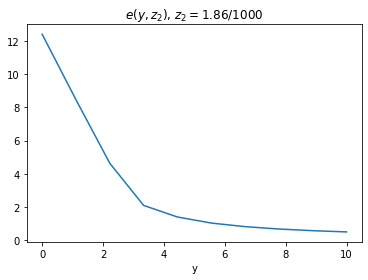

In [19]:
plt.plot(y_grid, e_grid[5])
plt.xlabel('y')
plt.title(r'$e(y, z_2)$, $z_2=1.86/1000$')
# plt.ylim(0, 1)

In [ ]:
@njit
def simulation(y_grid, z_grid, e_grid, yoz_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    z = z_grid[z_loc]
    for i in range(T+1):
        Et[i] = np.interp(yoz_start*z, y_grid, e_grid[z_loc])
        yoz_start = yoz_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [ ]:
T = 100
Et = simulation(y_grid, z_grid, e_grid, yoz_start=290, z_loc=25, T=T)

In [ ]:
plt.figure()
plt.title('Emission trajectory')
plt.plot(Et)
plt.xlabel('Year')

## SCC computation

$$
SCC = ME(y, z_2) \frac{(\alpha-i^*)\exp(k-n)}{\delta(1-\eta)}
$$

In our uncertainty decompositions, we compute $ME$ in the following four steps:

i) compute
$$
ME_1(y, z_2) = (1-\eta)\left(\sum_{j=1}^J\pi_jz_2\frac{d}{d \tau}\Lambda_j (y)\right)
$$

ii) construct
$$
U(y, z_2) = (1-\eta) \left[\sum_{j=1}^J\pi_jz_2^2 \frac{d^2}{d\tau^2}\Lambda_j (y) e^*(y, z_2)\right]
$$

iii) solve
$$
0 = -\delta f + \frac{\partial f}{\partial y}e^* + \frac{\partial f}{\partial z_2}\left[-\rho(z_2 - \sum_{j}^J \pi_j\mu_{2,j})\right] + \left[\frac{\partial^2 f}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

iv) then $ME_2(y, z_2)=f(y, z_2)$, and $ME(y, z_2) = ME_1(y, z_2) + ME_2(y, z_2)$